In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import timedelta, datetime
import time

# 파이썬 버전은 무조건 3.10 이상으로 접근한다.

In [66]:
def fetch_historical_orders(wallet_address):
    """Hyperliquid에서 사용자의 과거 주문 내역을 가져와 DataFrame으로 변환"""
    
    url_orders = "https://api.hyperliquid.xyz/info"
    headers = {"Content-Type": "application/json"}

    # 요청 바디 설정
    body_orders = {
        "type": "historicalOrders",
        "user": wallet_address  # 지갑 주소
    }

    # API 요청
    response = requests.post(url_orders, headers=headers, json=body_orders)

    if response.status_code == 200:
        data = response.json()

        # 주문 데이터가 존재하지 않으면 빈 DataFrame 반환
        if not data or not isinstance(data, list):
            print("❌ 주문 데이터 없음.")
            return pd.DataFrame()

        # ✅ 필요한 데이터만 추출
        orders_list = []
        for item in data:
            order = item.get("order", {})  # order 키 안에 있는 데이터 가져오기
            orders_list.append({
                "Coin": order.get("coin"),
                "Side": order.get("side"),
                "Limit Price": float(order.get("limitPx", 0)),
                "Size": float(order.get("sz", 0)),
                "Order ID": order.get("oid"),
                "Timestamp": pd.to_datetime(order.get("timestamp"), unit="ms"),  # 시간 변환
                "Trigger Condition": order.get("triggerCondition"),
                "Is Trigger": order.get("isTrigger"),
                "Trigger Price": float(order.get("triggerPx", 0)),
                "Order Type": order.get("orderType"),
                "Original Size": float(order.get("origSz", 0)),
                "Reduce Only": order.get("reduceOnly")
            })

        # ✅ DataFrame 변환
        df_orders = pd.DataFrame(orders_list)

        return df_orders
    else:
        print(f"❌ API 요청 실패: {response.status_code} - {response.text}")
        return pd.DataFrame()

# ✅ 실행 예제
wallet_address = "0x5e57111634c43a8c376Fe5b9Bc39F60A4c8D6Ac6"
df_orders = fetch_historical_orders(wallet_address) # 지갑 정보에 대한 주문내역 생성

In [3]:
def filtering_data(data):
    """
    'Coin' 열이 '@'로 시작하는 데이터를 필터링하여 새로운 DataFrame으로 반환하는 함수.
    """
    if "Coin" not in data.columns:
        print("❌ 'Coin' 열이 데이터에 존재하지 않습니다.")
        return pd.DataFrame()

    # '@'로 시작하는 코인 필터링
    filtered_df = data[data["Coin"].str.startswith("@")].copy()

    return filtered_df

In [4]:
df_orders = filtering_data(df_orders)

In [31]:
# ✅ API 엔드포인트
url_candles = "https://api.hyperliquid.xyz/info"

# ✅ 가져올 코인 목록 (여러 개 가능)
coin_list = np.unique(df_orders["Coin"]).tolist()  # 원하는 코인 추가 가능

# ✅ 현재 시간 설정 (밀리초 단위)
current_time = int(pd.Timestamp.now().timestamp() * 1000)
start_time = current_time - (15 * 60 * 1000)  # 최근 15분 캔들 데이터 요청

# ✅ API 요청을 보낼 헤더 설정
headers = {"Content-Type": "application/json"}

# ✅ 코인별 캔들 데이터 요청
df_candles_list = []

for coin in coin_list:
    print(f"📢 {coin} 현재 가격 요청 중...")
    time.sleep(1)  # API Rate Limit 방지 (1초 대기)

    # ✅ API 요청 바디
    body_candles = {
        "type": "candleSnapshot",
        "req": {
            "coin": coin,
            "interval": "1m",  # 1분 봉 기준
            "startTime": start_time,
            "endTime": current_time
        }
    }

    # ✅ API 요청 실행
    response = requests.post(url_candles, headers=headers, json=body_candles)

    # ✅ 응답 확인
    if response.status_code == 200:
        candles = response.json()
        if candles:
            latest_candle = candles[-1]  # 가장 최신 데이터만 가져옴
            df_candles_list.append({
                "Coin": coin,
                "Timestamp": latest_candle["t"],
                "Close Price": float(latest_candle["c"]),
                "High": float(latest_candle["h"]),
                "Low": float(latest_candle["l"]),
                "Open": float(latest_candle["o"]),
                "Volume": float(latest_candle["v"]),
                "Trade Count": latest_candle["n"]
            })
    else:
        print(f"❌ {coin} API 요청 실패: {response.status_code}")

# ✅ DataFrame 변환 및 시간 변환
df_candles = pd.DataFrame(df_candles_list)

📢 @105 현재 가격 요청 중...
📢 @107 현재 가격 요청 중...
📢 @115 현재 가격 요청 중...
📢 @123 현재 가격 요청 중...
📢 @124 현재 가격 요청 중...
📢 @126 현재 가격 요청 중...
📢 @27 현재 가격 요청 중...
📢 @35 현재 가격 요청 중...
📢 @44 현재 가격 요청 중...
📢 @56 현재 가격 요청 중...
📢 @87 현재 가격 요청 중...


In [32]:
# ✅ API 엔드포인트
coin_list = np.unique(df_orders["Coin"]).tolist()  # 원하는 코인 추가 가능

url_candles = "https://api.hyperliquid.xyz/info"


# ✅ 현재 시간 설정 (밀리초 단위)
current_time = int(pd.Timestamp.now().timestamp() * 1000)

# ✅ API 요청을 보낼 헤더 설정
headers = {"Content-Type": "application/json"}

# ✅ 캔들 데이터 요청 실행
latest_candle_data = []

for coin in coin_list:
    print(f"📢 {coin} 최신 캔들 데이터 요청 중...")

    # ✅ API 요청 바디
    body_candles = {
        "type": "candleSnapshot",
        "req": {
            "coin": coin,
            "interval": "1m",  # 1일 단위 캔들 데이터
            "startTime": current_time - (7 * 24 * 60 * 60 * 1000),  # 최근 7일 데이터 요청
            "endTime": current_time
        }
    }

    # ✅ API 요청 실행
    response = requests.post(url_candles, headers=headers, json=body_candles)

    # ✅ 응답 확인
    if response.status_code == 200:
        candles = response.json()
        if candles:
            df_candles = pd.DataFrame(candles)
            df_candles["coin"] = coin  # 코인 이름 추가

            # ✅ 컬럼명 직관적으로 변경
            df_candles = df_candles.rename(columns={
                "t": "Start Time",
                "T": "End Time",
                "s": "Symbol",
                "i": "Interval",
                "o": "Open",
                "c": "Close",
                "h": "High",
                "l": "Low",
                "v": "Volume",
                "n": "Trade Count"
            })

            # ✅ 시간 변환
            df_candles["Start Time"] = pd.to_datetime(df_candles["Start Time"], unit="ms")
            df_candles["End Time"] = pd.to_datetime(df_candles["End Time"], unit="ms")

            # ✅ 가장 최근 데이터 1개만 추출
            latest_candle = df_candles.iloc[-1:]
            latest_candle_data.append(latest_candle)
    else:
        print(f"❌ {coin} API 요청 실패: {response.status_code}")

# ✅ 최종 최신 캔들 데이터 생성
df_latest_candle = pd.concat(latest_candle_data, ignore_index=True) if latest_candle_data else pd.DataFrame()

📢 @105 최신 캔들 데이터 요청 중...
📢 @107 최신 캔들 데이터 요청 중...
📢 @115 최신 캔들 데이터 요청 중...
📢 @123 최신 캔들 데이터 요청 중...
📢 @124 최신 캔들 데이터 요청 중...
📢 @126 최신 캔들 데이터 요청 중...
📢 @27 최신 캔들 데이터 요청 중...
📢 @35 최신 캔들 데이터 요청 중...
📢 @44 최신 캔들 데이터 요청 중...
📢 @56 최신 캔들 데이터 요청 중...
📢 @87 최신 캔들 데이터 요청 중...


In [68]:
#  데이터 병합 (코인명을 기준으로 매칭)
df_merged = pd.merge(df_orders, df_latest_candle, left_on="Coin", right_on="coin", how="left")
df_merged = df_merged[df_merged["Size"]>0]


NameError: name 'df_latest_candle' is not defined

In [50]:
df_merged


,Coin,Side,Limit Price,Size,Order ID,Timestamp,Trigger Condition,Is Trigger,Trigger Price,Order Type,...,End Time,Symbol,Interval,Open,Close,High,Low,Volume,Trade Count,coin
1,@107,A,19.275000,2.85,63420371432,2025-01-16 10:57:58.454,N/A,False,0.0,Market,...,2025-02-13 09:33:59.999,@107,1m,25.468,25.489,25.575,25.44,14915.5,263,@107
3,@107,B,27.500000,2.85,58563722781,2024-12-25 14:13:34.946,N/A,False,0.0,Limit,...,2025-02-13 09:33:59.999,@107,1m,25.468,25.489,25.575,25.44,14915.5,263,@107
4,@107,B,27.500000,2.85,58562090386,2024-12-25 14:03:21.492,N/A,False,0.0,Limit,...,2025-02-13 09:33:59.999,@107,1m,25.468,25.489,25.575,25.44,14915.5,263,@107
5,@107,B,27.500000,2.85,58562090386,2024-12-25 14:03:21.492,N/A,False,0.0,Limit,...,2025-02-13 09:33:59.999,@107,1m,25.468,25.489,25.575,25.44,14915.5,263,@107
6,@107,B,28.073000,1.42,58560249333,2024-12-25 13:49:59.680,N/A,False,0.0,Limit,...,2025-02-13 09:33:59.999,@107,1m,25.468,25.489,25.575,25.44,14915.5,263,@107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,@107,B,27.147000,0.18,55752245991,2024-12-16 09:44:40.670,N/A,False,0.0,Limit,...,2025-02-13 09:33:59.999,@107,1m,25.468,25.489,25.575,25.44,14915.5,263,@107
145,@44,B,0.071814,39.00,55752153849,2024-12-16 09:43:39.862,N/A,False,0.0,Market,...,2025-02-13 08:12:59.999,@44,1m,0.0026066,0.0026144,0.0026144,0.0026066,19211.0,2,@44
147,@107,B,29.378000,0.40,55752069289,2024-12-16 09:42:56.770,N/A,False,0.0,Market,...,2025-02-13 09:33:59.999,@107,1m,25.468,25.489,25.575,25.44,14915.5,263,@107
149,@123,A,24.073000,0.60,55752016661,2024-12-16 09:42:31.977,N/A,False,0.0,Market,...,2025-02-13 09:32:59.999,@123,1m,14.556,14.556,14.556,14.556,1.1,1,@123


In [63]:
import os
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

def generate_pnl_card(output_path, eth_address, df_assets, up_image_path, down_image_path):
    """
    포트폴리오 PnL 카드 생성 함수
    
    Args:
        output_path (str): 생성된 이미지 저장 경로
        eth_address (str): 사용자의 이더리움 지갑 주소
        df_assets (pd.DataFrame): 자산 정보 데이터프레임 (컬럼: ['Coin', 'Avg_Buy_Price', 'Total_Buy_Size', 'PnL($)', 'PnL(%)'])
        up_image_path (str): PnL이 양수일 때 사용할 배경 이미지 경로
        down_image_path (str): PnL이 음수일 때 사용할 배경 이미지 경로
    """
    
    # PnL 계산
    total_pnl = df_assets["PnL($)"].sum()
    total_investment = (df_assets["Avg_Buy_Price"] * df_assets["Total_Buy_Size"]).sum()
    portfolio_pnl_percent = (total_pnl / total_investment) * 100 if total_investment > 0 else 0
    
    # PnL이 양수이면 up 이미지, 음수이면 down 이미지 사용
    image_path = up_image_path if total_pnl >= 0 else down_image_path
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"{image_path} 파일이 존재하지 않습니다!")
    
    # 이미지 불러오기
    up_image = Image.open(image_path)
    draw = ImageDraw.Draw(up_image)
    img_width, img_height = up_image.size
    
    # 폰트 설정
    font_path = "/Library/Fonts/noto/NotoSans-Bold.ttf"
    font_pnl_title = ImageFont.truetype(font_path, 70)
    font_pnl_value = ImageFont.truetype(font_path, 80)
    font_header = ImageFont.truetype(font_path, 25)
    font_small = ImageFont.truetype(font_path, 20)
    font_address = ImageFont.truetype(font_path, 20)
    font_bottom = ImageFont.truetype(font_path, 20)
    
    # 헤더 정보 및 위치 설정
    text_pnl = "Portfolio PnL"
    text_bottom = "Created by hypurrQuant.xyz"
    
    header_labels = df_assets.columns.tolist()
    padding = 50
    shift_x = 20
    
    header_spacing = [
        padding + (img_width // len(header_labels)) * i for i in range(len(header_labels))
    ]
    
    y_header = img_height // 2 - 100  
    
    # 포트폴리오 PnL 텍스트 색상
    text_color_pnl_title = (255, 255, 255)
    pnl_value_color = (255, 128, 128) if portfolio_pnl_percent < 0 else (173, 216, 230)
    
    # PnL 제목 표시
    x_pnl = padding  
    y_pnl = y_header - 350
    draw.text((x_pnl, y_pnl), text_pnl, fill=text_color_pnl_title, font=font_pnl_title)
    
    # PnL 값 표시
    x_pnl_value = x_pnl + 30  
    y_pnl_value = y_pnl + 150
    draw.text((x_pnl_value, y_pnl_value), f"{portfolio_pnl_percent:.2f}%", fill=pnl_value_color, font=font_pnl_value)
    
    # 컬럼 헤더 출력
    for i, label in enumerate(header_labels):
        bbox = draw.textbbox((0, 0), label, font=font_header)
        text_width = bbox[2] - bbox[0]
        x_position = header_spacing[i] - (text_width // 2)
        draw.text((x_position, y_header), label, fill=(255, 255, 255), font=font_header)
    
    # 자산 데이터 출력
    y_asset = y_header + 60  
    for _, row in df_assets.iterrows():
        pnl_value_color = (255, 128, 128) if row["PnL($)"] < 0 else (255, 255, 255)
        
        asset_data = [str(row[col]) for col in df_assets.columns]
        for i, value in enumerate(asset_data):
            bbox = draw.textbbox((0, 0), value, font=font_small)
            text_width = bbox[2] - bbox[0]
            x_position = header_spacing[i] - (text_width // 2)
            text_fill = pnl_value_color if i in [3, 4] else (255, 255, 255)
            draw.text((x_position, y_asset), value, fill=text_fill, font=font_small)
        y_asset += 35  
    
    # 지갑 주소 출력
    bbox = draw.textbbox((0, 0), eth_address, font=font_address)
    x_address = img_width - padding - (bbox[2] - bbox[0])
    y_address = img_height - 50
    draw.text((x_address-100, y_address), f"ETH address: {eth_address}", fill=(255, 255, 255), font=font_address)
    
    # 하단 문구 출력
    draw.text((padding, img_height - 50), text_bottom, fill=(255, 255, 255), font=font_bottom)
    
    # 이미지 저장 및 출력
    up_image.show()
    up_image.save(output_path) # 이미지 저장
    print(f"이미지 출력 완료: {output_path}")

In [64]:
generate_pnl_card("/Users/ijongseung/pnlc/output_image.png", "0x157a44B0555B31A0642fd0aF47f6806D3b86Ec9f", df_selected, "/Users/ijongseung/pnlc/up.jpeg", "/Users/ijongseung/pnlc/output_image.png")

NameError: name 'df_selected' is not defined

In [47]:
import os
from PIL import Image, ImageDraw, ImageFont

# ✅ 이미지 경로 설정 (PnL 값에 따라 변경)
up_path = "/Users/ijongseung/pnlc/up.jpeg"
down_path = "/Users/ijongseung/pnlc/down.jpeg"

# ✅ PnL 계산
total_pnl = df_selected["PnL"].sum()
total_investment = (df_selected["Avg_Buy_Price"] * df_selected["Total_Buy_Size"]).sum()
portfolio_pnl_percent = (total_pnl / total_investment) * 100 if total_investment > 0 else 0

# ✅ PnL이 양수이면 up 이미지, 음수이면 down 이미지 사용
image_path = up_path if total_pnl >= 0 else down_path
if not os.path.exists(image_path):
    raise FileNotFoundError(f"{image_path} 파일이 존재하지 않습니다!")

# ✅ 선택된 이미지 로드
up_image = Image.open(image_path)
draw = ImageDraw.Draw(up_image)

img_width, img_height = up_image.size

# ✅ 폰트 설정
font_path = "/Library/Fonts/noto/NotoSans-Bold.ttf"
font_pnl_title = ImageFont.truetype(font_path, 70)
font_pnl_value = ImageFont.truetype(font_path, 80)
font_header = ImageFont.truetype(font_path, 25)
font_small = ImageFont.truetype(font_path, 20)
font_address = ImageFont.truetype(font_path, 20)
font_bottom = ImageFont.truetype(font_path, 20)

eth_address = "0x157a44B0555B31A0642fd0aF47f6806D3b86Ec9f"
text_pnl = "Portfolio PnL"
text_bottom = "Created by hypurrQuant.xyz"

header_labels = ["Coin", "Avg_Buy_Price", "Total_Buy_Size", "PnL($)", "PnL(%)"]

padding = 50
shift_x = 20

y_header = img_height // 2 - 100  # DF를 위로 이동

header_spacing = [
    padding,
    (img_width // 6) + shift_x,
    ((img_width // 6) * 2) + shift_x,
    ((img_width // 6) * 3) + shift_x,
    ((img_width // 6) * 4) + shift_x,
    ((img_width // 6) * 5) + shift_x
]

# ✅ 포트폴리오 PnL 텍스트는 흰색 유지
text_color_pnl_title = (255, 255, 255)

# ✅ PnL 숫자가 음수이면 연한 빨강 적용, 양수면 기본 색상(파란색 계열)
pnl_value_color = (255, 128, 128) if portfolio_pnl_percent < 0 else (173, 216, 230)

# ✅ PnL 제목 표시 (흰색)
x_pnl = padding  
y_pnl = y_header - 350  # 이 부분 절대 건들지 말것
draw.text((x_pnl, y_pnl), text_pnl, fill=text_color_pnl_title, font=font_pnl_title)

# ✅ PnL 값 표시 (연한 빨강 or 기본 색상)
x_pnl_value = x_pnl + 30  
y_pnl_value = y_pnl + 150
draw.text((x_pnl_value, y_pnl_value), f"{portfolio_pnl_percent:.2f}%", fill=pnl_value_color, font=font_pnl_value)

# ✅ 컬럼 헤더는 기본 흰색 유지
header_text_color = (255, 255, 255)

for i, label in enumerate(header_labels):
    bbox = draw.textbbox((0, 0), label, font=font_header)
    text_width = bbox[2] - bbox[0]
    x_position = header_spacing[i] - (text_width // 2)
    draw.text((x_position, y_header), label, fill=header_text_color, font=font_header)

y_asset = y_header + 60
for _, row in df_selected.iterrows():
    # ✅ 각 자산별 PnL 숫자가 음수이면 연한 빨강 적용
    pnl_value_color = (255, 128, 128) if row["PnL"] < 0 else (255, 255, 255)

    asset_data = [
        row["Coin"],
        f"{row['Total_Buy_Size']:.2f}",
        f"{row['Avg_Buy_Price']:.4f}",
        f"{row['PnL']:.2f}",
        f"{row['PnL%']:.2f}%"
    ]

    for i, value in enumerate(asset_data):
        bbox = draw.textbbox((0, 0), value, font=font_small)
        text_width = bbox[2] - bbox[0]
        x_position = header_spacing[i] - (text_width // 2)

        # ✅ PnL 값만 연한 빨강 적용
        text_fill = pnl_value_color if i in [3, 4] else (255, 255, 255)
        draw.text((x_position, y_asset), value, fill=text_fill, font=font_small)

    y_asset += 35

# ✅ 지갑 주소를 우측 하단에 배치
bbox = draw.textbbox((0, 0), eth_address, font=font_address)
x_address = img_width - padding - (bbox[2] - bbox[0])
y_address = img_height - 50
draw.text((x_address-100, y_address), f"ETH address :{eth_address}", fill=(256, 256, 256), font=font_address)

# ✅ 하단 문구 추가
draw.text((padding, img_height - 50), text_bottom, fill=(255, 255, 255), font=font_bottom)

# ✅ 이미지 저장 및 출력
output_path = "/Users/ijongseung/pnlc/output_image.png"
up_image.save(output_path)
up_image.show()

print(f"✅ 이미지 출력 완료: {output_path}")


✅ 이미지 출력 완료: /Users/ijongseung/pnlc/output_image.png


In [70]:
import requests
import json

# ✅ API 엔드포인트 설정
API_URL = "https://api.hyperliquid.xyz/info"

# ✅ 사용자의 지갑 주소 (예시)
user_address = "0x157a44B0555B31A0642fd0aF47f6806D3b86Ec9f"

# ✅ 요청 본문 설정
payload = {
    "type": "spotClearinghouseState",
    "user": user_address
}

# ✅ 요청 헤더 설정
headers = {
    "Content-Type": "application/json"
}

# ✅ API 요청 보내기
response = requests.post(API_URL, headers=headers, data=json.dumps(payload))

# ✅ 응답 데이터 확인
if response.status_code == 200:
    data = response.json()
    print("✅ 데이터 불러오기 성공!")
    # print(json.dumps(data, indent=4))  # JSON 데이터 출력
else:
    print(f"❌ API 요청 실패! 상태 코드: {response.status_code}")
    print(response.text)

✅ 데이터 불러오기 성공!


### 현재 기준의 미실현 PnL 카드 생성

In [2]:
import requests
import json
import pandas as pd
import numpy as np
API_URL = "https://api.hyperliquid.xyz/info"

user_address = "0x157a44B0555B31A0642fd0aF47f6806D3b86Ec9f" # 김희상 주소

payload = {
    "type": "spotClearinghouseState",
    "user": user_address
}

headers = {
    "Content-Type": "application/json"
}

response = requests.post(API_URL, headers=headers, data=json.dumps(payload))

if response.status_code == 200:
    data = response.json()
    print("✅ 데이터 불러오기 성공!")
    # print(json.dumps(data, indent=4))  # JSON 데이터 출력
else:
    print(f"❌ API 요청 실패! 상태 코드: {response.status_code}")
    print(response.text)
# ✅ DataFrame 변환
df_balances = pd.DataFrame(data["balances"])

df_balances[["total", "hold", "entryNtl"]] = df_balances[["total", "hold", "entryNtl"]].astype(float)


✅ 데이터 불러오기 성공!


In [51]:
def fetch_spot_meta():
    api_url = "https://api.hyperliquid.xyz/info"

    headers = {"Content-Type": "application/json"}

    payload = {"type": 'spotMetaAndAssetCtxs'}

    response = requests.post(api_url, headers=headers, data=json.dumps(payload))
    response.raise_for_status()

    data = response.json()

    tokens = pd.DataFrame(data[0]["tokens"]).rename(columns={"name": "Tname"})
    universe = pd.DataFrame(data[0]["universe"]).rename(columns={"name": "coin"})

    tokens = tokens.merge(universe, left_on="index", right_on="index", how="inner")
    return tokens

spot_meta = fetch_spot_meta()
spot_meta1 = spot_meta[["Tname", "coin"]] # tname이랑 coin이름을 매칭시켜 둔 경우를 뜻함

# 이후 spot_meta1에서 정보매칭 후 해당되는 값만 가지고 오기
def match_coin():
    spot_meta1 = spot_meta[["Tname", "coin"]] 
    owner_df = pd.DataFrame()
    
    tname_list = []
    # 현재 지갑에서 보유하고 있는 데이터를 추출한다.
    for coin_name in df_balances["coin"].values.tolist():
        tname_list.append(spot_meta1[spot_meta1["Tname"]==coin_name]["coin"].values.tolist())

    # 중첩 리스트 생성해서 접근
    flattened_list = [item for sublist in tname_list for item in sublist]

    return flattened_list

In [54]:
ss = match_coin()

In [56]:
df_balances

,coin,token,total,hold,entryNtl
0,USDC,0,44.637870,0.0,0.000000
1,TRUMP,10,89.883297,0.0,1.328040
2,GPT,35,54.662673,0.0,0.008136
3,PILL,45,0.550000,0.0,0.005280
4,TJIF,77,0.010461,0.0,0.005944
5,H,109,0.070000,0.0,0.000005
6,HYPE,150,198.603685,0.0,4955.372043
7,FARM,161,0.000000,0.0,0.000000


In [57]:
ss

['PURR/USDC', '@10', '@35', '@45', '@77', '@109']

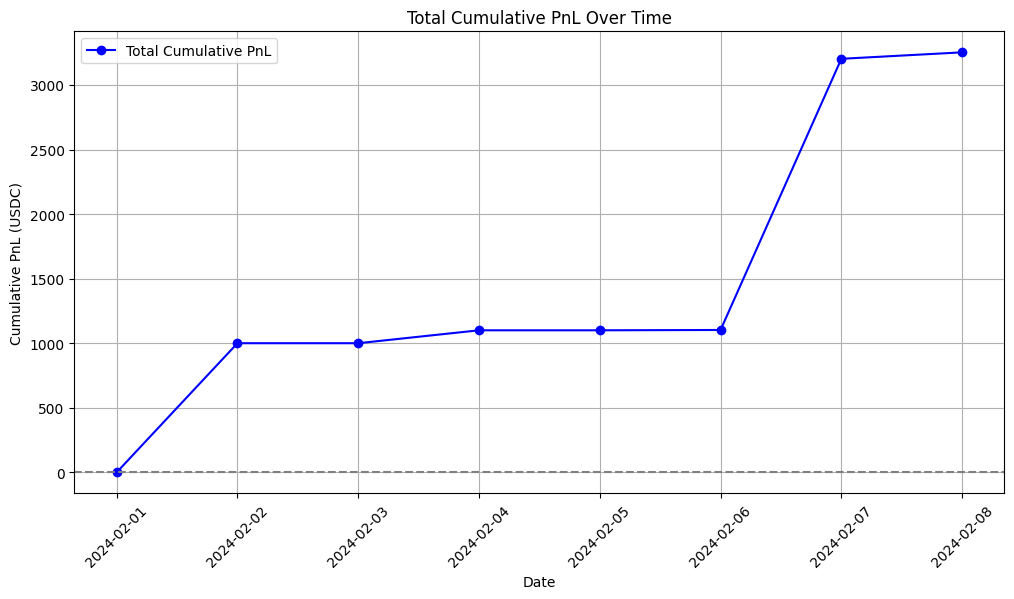

In [62]:
# ✅ 예제 데이터 (각 코인의 거래 내역)
df_trades = pd.DataFrame([
    {"timestamp": "2024-02-01", "coin": "BTC", "side": "B", "price": 40000, "size": 0.5},
    {"timestamp": "2024-02-02", "coin": "BTC", "side": "S", "price": 45000, "size": 0.2},
    {"timestamp": "2024-02-03", "coin": "ETH", "side": "B", "price": 3000, "size": 1},
    {"timestamp": "2024-02-04", "coin": "ETH", "side": "S", "price": 3200, "size": 0.5},
    {"timestamp": "2024-02-05", "coin": "TRUMP", "side": "B", "price": 0.1, "size": 100},
    {"timestamp": "2024-02-06", "coin": "TRUMP", "side": "S", "price": 0.15, "size": 50},
    {"timestamp": "2024-02-07", "coin": "BTC", "side": "S", "price": 47000, "size": 0.3},
    {"timestamp": "2024-02-08", "coin": "ETH", "side": "S", "price": 3100, "size": 0.5},
])

# ✅ 날짜 변환
df_trades["timestamp"] = pd.to_datetime(df_trades["timestamp"])

# ✅ 각 코인의 평균 매수가 계산 (매수(B) 거래의 평균가)
df_avg_buy = df_trades[df_trades["side"] == "B"].groupby("coin")["price"].mean().rename("avg_buy_price")
df_trades = df_trades.merge(df_avg_buy, on="coin", how="left")

# ✅ 실현 PnL 계산 (매도(S) 시점에서 발생)
df_trades["Realized PnL"] = df_trades.apply(
    lambda row: (row["price"] - row["avg_buy_price"]) * row["size"] if row["side"] == "S" else 0,
    axis=1
)

# ✅ 전체 누적 PnL 계산 (모든 코인 합산)
df_trades["Cumulative PnL"] = df_trades["Realized PnL"].cumsum()

# ✅ 전체 PnL 그래프 시각화
plt.figure(figsize=(12, 6))
plt.plot(df_trades["timestamp"], df_trades["Cumulative PnL"], marker='o', linestyle='-', color='b', label="Total Cumulative PnL")

plt.axhline(0, color='gray', linestyle='--')  # 0 기준선 추가
plt.xlabel("Date")
plt.ylabel("Cumulative PnL (USDC)")
plt.title("Total Cumulative PnL Over Time")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()
